# Overview

Given the Ames Housing data, predict the final price of each home

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#Importing data
test = pd.read_csv("./test.csv")
train = pd.read_csv("./train.csv")

train.columns = train.columns.str.replace(" ", "")
test.columns = test.columns.str.replace(" ", "")

train.info

<bound method DataFrame.info of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Ut

In [3]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# DistPlot Analysis

Upon visual inspection of the plot, it is evident that the distribution is positively skewed(skewed to the right), deviating significantly from a normal distribution. This skewness can have detrimental effects on predictive accuracy and may introduce bias into the machine learning model in later stages.
 
Employing the Shapiro-Wilk test for normality further reinforces this observation, as the obtained p-value is exceedingly small, indicating a departure from normality. Typically, a conventional threshold of 0.05 is used to determine whether the p-value is considered small. In this case, the p-value is practically zero, hence the null hypothesis will be rejected. Addressing this skewness issue will be crucial, and one potential approach could involve applying a normalization technique to the data.



C:\Users\NicholasTeng\AppData\Local\Temp\ipykernel_4756\1405735696.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["SalePrice"],fit=norm)
c:\Users\NicholasTeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\NicholasTeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

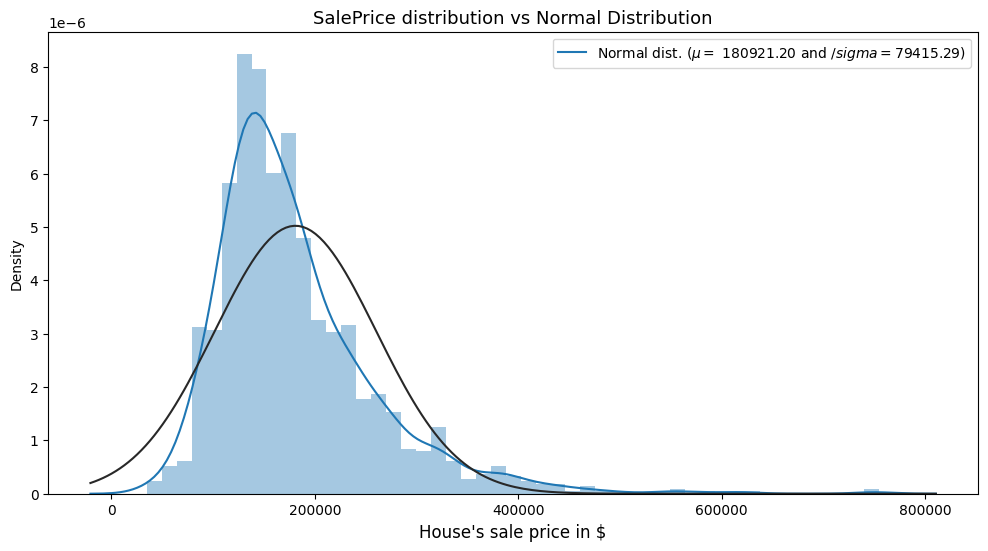

In [4]:
#Exploratory Data Analysis and Visualisation

(mu, sigma) = norm.fit(train["SalePrice"])
plt.figure(figsize = (12,6))

sns.distplot(train["SalePrice"],fit=norm)

plt.title("SalePrice distribution vs Normal Distribution", fontsize = 13)
plt.xlabel("House's sale price in $", fontsize = 12)
plt.legend(["Normal dist. ($\mu=$ {:.2f} and $/sigma=${:.2f})".format(mu, sigma)], loc = "best")
plt.show()

In [5]:
# Skew and kurt
from scipy import stats

shap_t,shap_p = stats.shapiro(train['SalePrice'])

print("Shapiro Test Statistic: %f" % shap_t)
print("Shapiro P value: %f" % shap_p)

Shapiro Test Statistic: 0.869673
Shapiro P value: 0.000000


# Correlation Matrix Analysis
The Correlation Matrix serves as a crucial tool in identifying the features that exert the most significant influence on a house's sales price. By leveraging this insight, we can strategically select features for constructing the ML model, resulting in a reduction of noise and an improvement in accuracy. These influential features will also be subjected to a more comprehensive examination.

However, it's worth noting that even features with weaker correlations can be leveraged to generate additional variables that may still offer meaningful contributions to the model.

Upon analyzing the Correlation Matrix, it becomes evident that features such as OverallQual (0.79), GrLivArea (0.71), 1stFlrSF (0.61), GarageCars (0.64), FullBath (0.61), and YearBuilt (0.52) exhibit the highest correlations with SalesPrice. These will play a pivotal role in training the ML model.

As for the exclusion of certain features like GarageArea, the rationale lies in the assumption that its correlation primarily stems from the number of cars it can accommodate, a relationship already captured by GarageCars. Given the higher correlation of GarageCars, it takes precedence to avoid potential overfitting to the garage aspect. A similar logic applies to the choice between BsmtSF and 1stFlrSF. Nevertheless, these excluded features can still be valuable in subsequent stages of feature engineering.

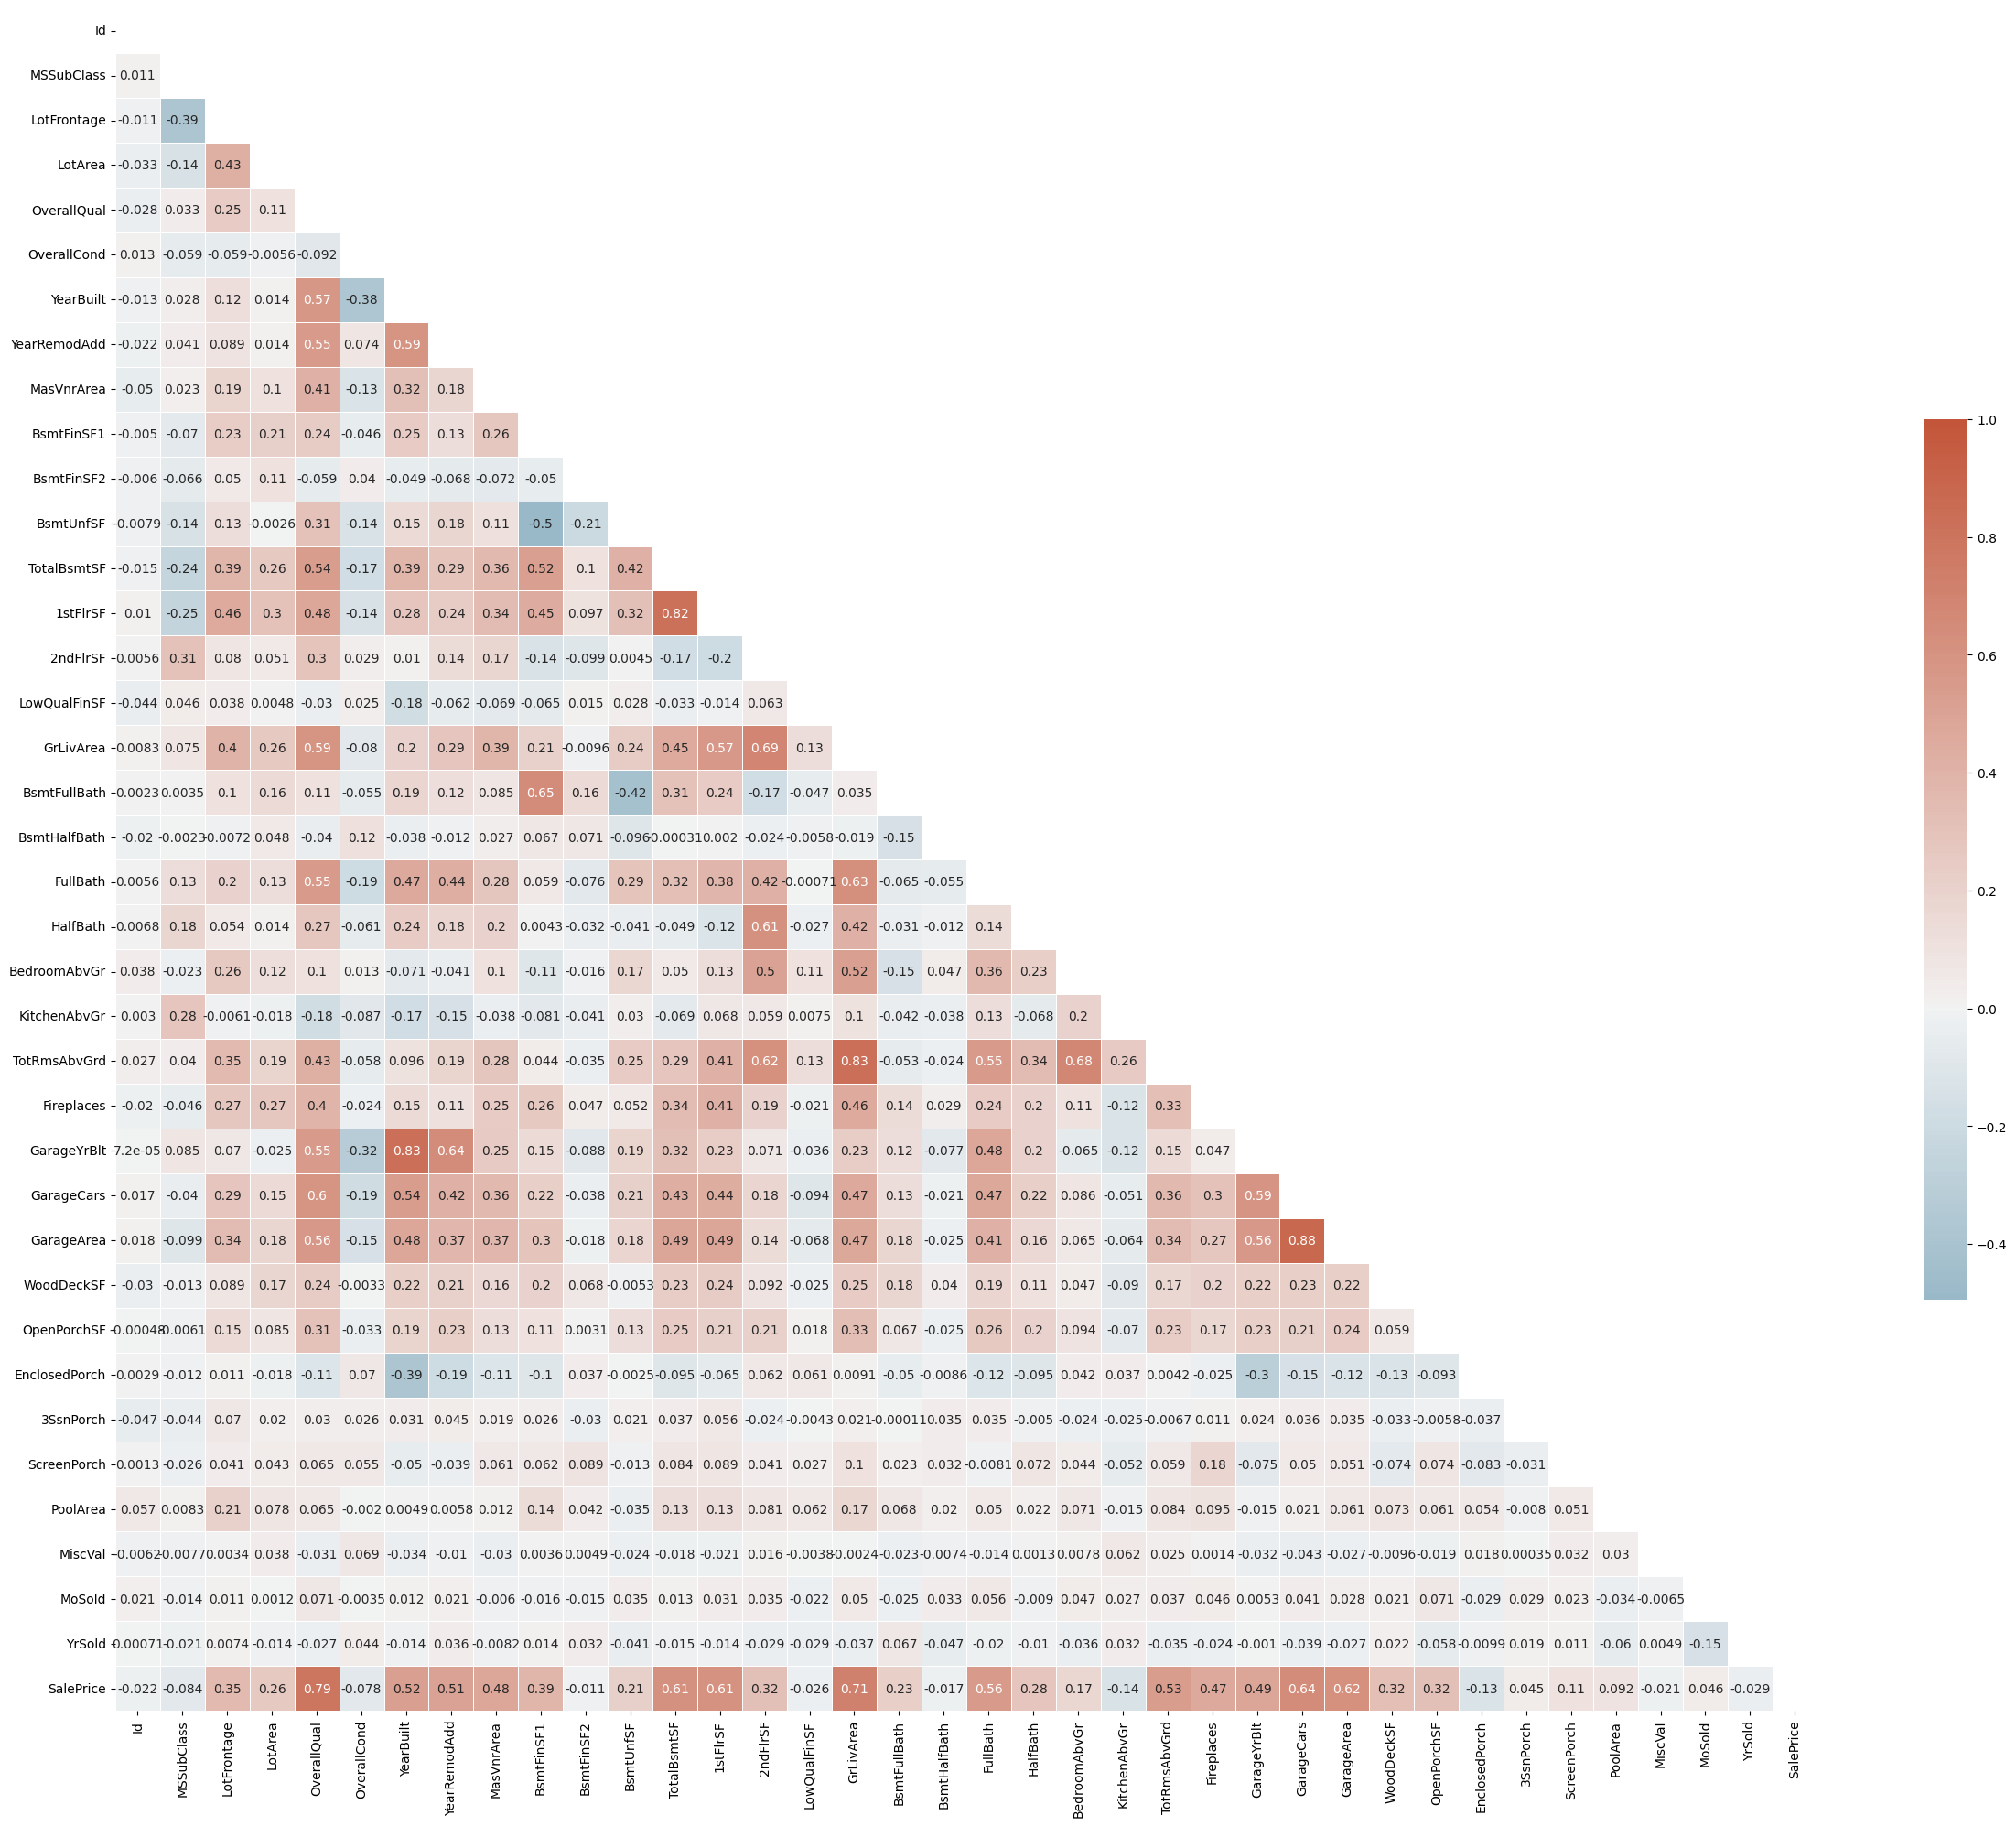

In [6]:
#Correlation Matrix
f, ax = plt.subplots(figsize=(30, 25))
numeric_data = train.select_dtypes(include=['number'])
mat = numeric_data.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Selected Feaures Plot

The chosen features are visualized to gain a deeper understanding of their correlation with SalePrice and to identify any noteworthy anomalies. Base on the plots, no anomalies are discoverd.

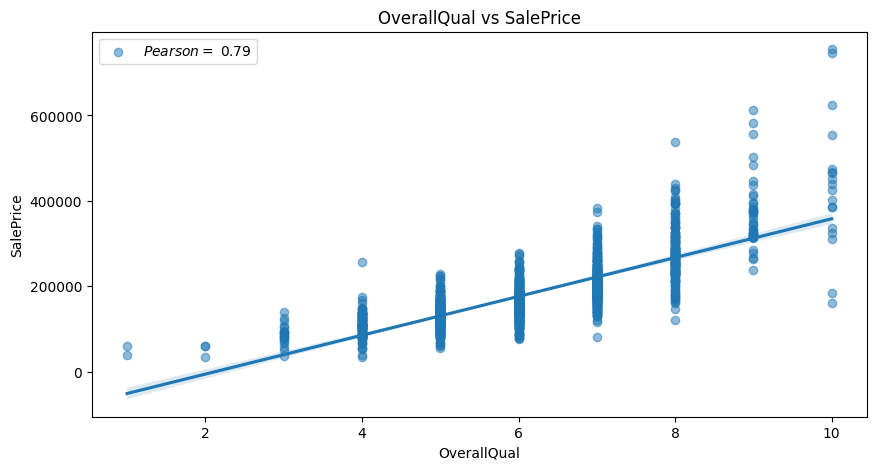

In [7]:
Pearson_OverallQual = 0.79
plt.figure(figsize = (10,5))
sns.regplot(data=train, x = 'OverallQual', y='SalePrice', scatter_kws={'alpha':0.5}, order =1 )
plt.title('OverallQual vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_OverallQual)], loc = 'best')
plt.show()

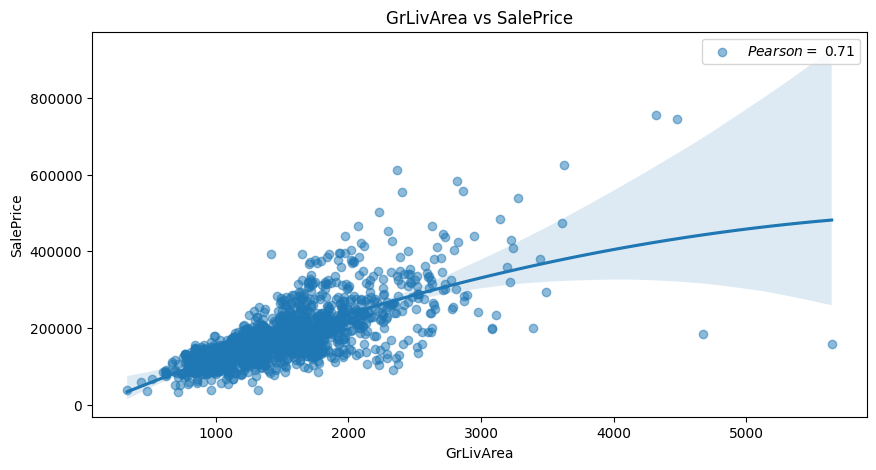

In [8]:
Pearson_GrLiv = 0.71
plt.figure(figsize = (10,5))
sns.regplot(data=train, x = 'GrLivArea', y='SalePrice', scatter_kws={'alpha':0.5}, order =2 )
plt.title('GrLivArea vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_GrLiv)], loc = 'best')
plt.show()

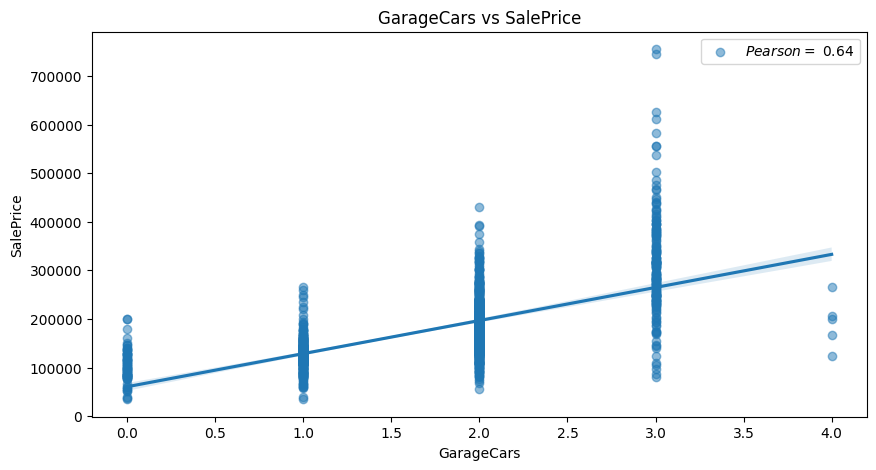

In [9]:
Pearson_GarageCars = 0.64
plt.figure(figsize = (10,5))
sns.regplot(data=train, x = 'GarageCars', y='SalePrice', scatter_kws={'alpha':0.5}, order =1 )
plt.title('GarageCars vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_GarageCars)], loc = 'best')
plt.show()

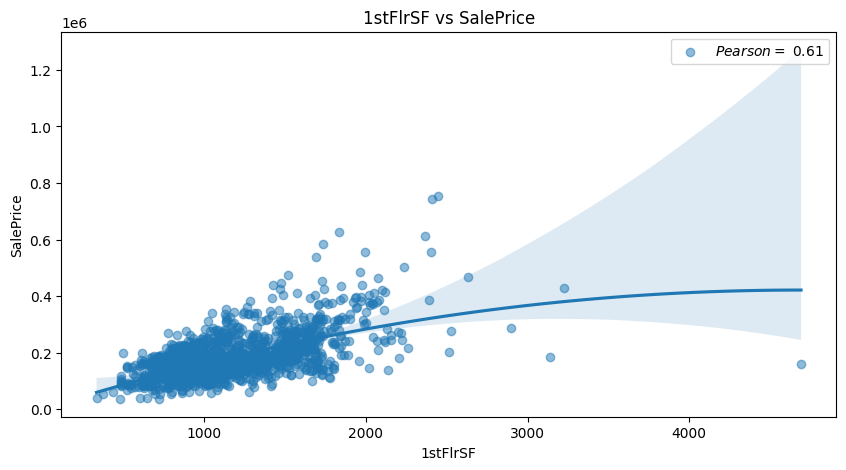

In [10]:
Pearson_1stFlrSF = 0.61
plt.figure(figsize = (10,5))
sns.regplot(data=train, x = '1stFlrSF', y='SalePrice', scatter_kws={'alpha':0.5}, order =2 )
plt.title('1stFlrSF vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_1stFlrSF)], loc = 'best')
plt.show()

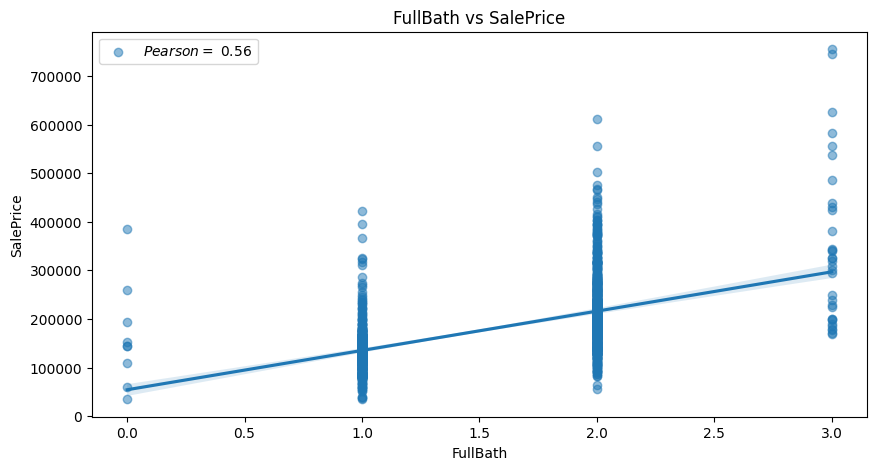

In [11]:
Pearson_FullBath = 0.56
plt.figure(figsize = (10,5))
sns.regplot(data=train, x = 'FullBath', y='SalePrice', scatter_kws={'alpha':0.5}, order =1 )
plt.title('FullBath vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_FullBath)], loc = 'best')
plt.show()

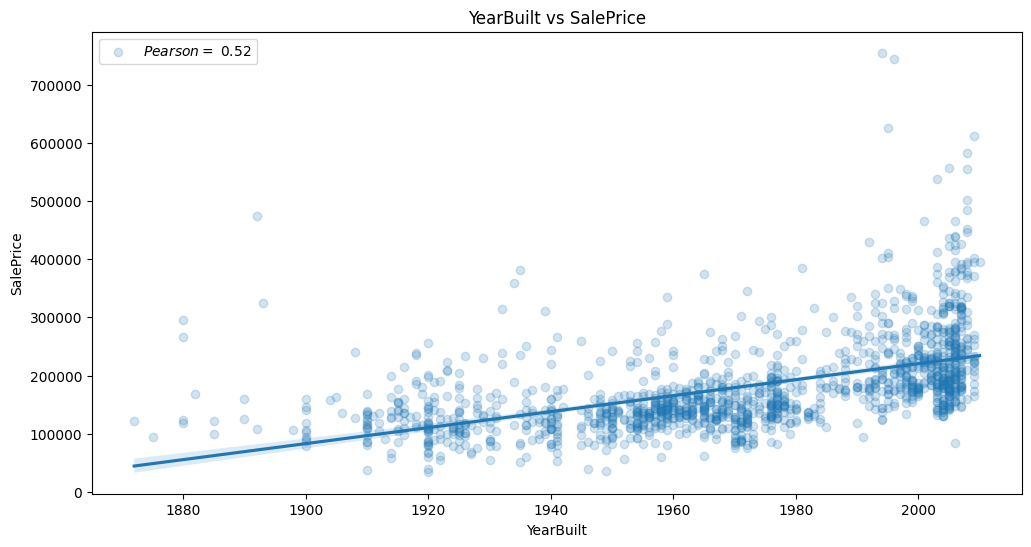

In [12]:
Pearson_YrBelt = 0.52
plt.figure(figsize=(12,6))
sns.regplot(data=train, x = "YearBuilt", y="SalePrice", scatter_kws={'alpha':0.2})
plt.title('YearBuilt vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_YrBelt)], loc = 'best')
plt.show()

# Data Processing

After finding the useful attributes. Before that, the train and test sets are concatenated so as to use the dataset "train_test". This is to clean both the trianing and testing data sets consistently, to prevent issues with the data shape, type and formats if they are cleaned separately.

Main steps of preprocessing are:

1. Looking for potential NaN
2. Dealing with categorical features (e.g. Dummy coding?)
3. Normalisation

In [13]:
#Separating Target and Features
#Try and do this, but with only training and testing data. Try and omit the main Housing AMV data stuff
target =train['SalePrice']
test_id = test['Id']
train_id = train['Id']
test = test.drop(['Id'], axis=1)
train_modified = train.drop(['SalePrice','Id'], axis=1)


#Concateenating train & trst set

train_test = pd.concat([train_modified,test], axis=0, sort=False)
train_test.reset_index(drop=True, inplace=True)
train_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


# 1. Looking for potential NaN sets

The number of NaN values within each column is summed up, and then found as a percentage of number of rows. If the NaN percentage exceeds 20%, it is deemed as non usable, even for feture engineering since attempting to fill the data up to make it usable, would likely lead the entire column to be too inaccurate. 

The features FireplaceQu, MasVnrType, Fence, Alley, MiscFeature, PoolQC	exceed the 20% threshold and hence, will be discarded.

In [14]:
# Looking at NaN % within the data
# This is quite useful, take note of this!

nan = pd.DataFrame(train_test.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/train_test.shape[0])*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan



,NaN_sum,feat,Perc(%),Usability
TotalBsmtSF,1,TotalBsmtSF,0.034258,Keep
GarageArea,1,GarageArea,0.034258,Keep
GarageCars,1,GarageCars,0.034258,Keep
KitchenQual,1,KitchenQual,0.034258,Keep
Electrical,1,Electrical,0.034258,Keep
BsmtUnfSF,1,BsmtUnfSF,0.034258,Keep
BsmtFinSF2,1,BsmtFinSF2,0.034258,Keep
BsmtFinSF1,1,BsmtFinSF1,0.034258,Keep
SaleType,1,SaleType,0.034258,Keep
Exterior1st,1,Exterior1st,0.034258,Keep


# Revisiting Discarded Features

Upon initial examination, the mentioned features seemed candidates for removal due to empty data. However, a closer look reveals that these empty entries signify the absence of the respective feature. For instance, a missing 'PoolQC' value implies the house lacks a pool. Thus, these apparent gaps can be appropriately filled with 'NA' to accurately represent the absence of the feature.

<Axes: >

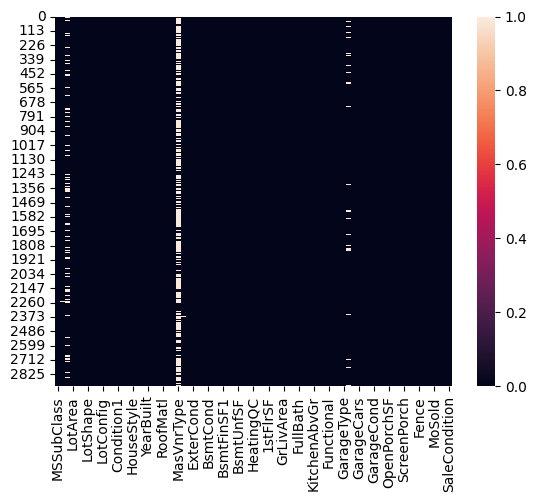

In [15]:
train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# Filling Categorical NaN (Filling based on description file)
train_test['Functional'] = train_test['Functional'].fillna('Typ') #Typ = Typical Functionality
train_test['Electrical'] = train_test['Electrical'].fillna("SBrkr") #SBrkr = Standard Circuit Breakers & Romex
train_test['KitchenQual'] = train_test['KitchenQual'].fillna("TA") #TA = Typical

for col in ['Exterior1st','Exterior2nd','SaleType']:
    train_test[col] = train_test[col].fillna(train_test[col].mode()[0])

for col in ('GarageArea', 'GarageCars'):
    train_test[col] = train_test[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_test[col] = train_test[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_test[col] = train_test[col].fillna('None')
    
for col in ['PoolQC', 'Alley', 'FireplaceQu', 'Fence','MiscFeature']:
    train_test[col] = train_test[col].fillna('None')

sns.heatmap(train_test.isna())
#The LotArea, MasVnrType and GarageCars show that they are NA, but they are actually non na.

# Utilizing KnnRegressor for imputation for numerical features

In [16]:
# Removing the useless variables

useless = ['GarageYrBlt','YearRemodAdd'] 
train_test = train_test.drop(useless, axis = 1)

# Imputing with KnnRegressor (we can also use different Imputers)

def impute_knn(df):
    ttn = df.select_dtypes(include=[np.number])
    ttc = df.select_dtypes(exclude=[np.number])

    cols_nan = ttn.columns[ttn.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ttn.columns.difference(cols_nan).values     # columns w/n nan
   

    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ttn.dropna(subset=[col])          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        # use the elbow technique to go and find out the number of neighbours to use. Migt not be 5
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])     #1st arg provies the features, 2nd arg is the target.
        #Revise K neighbours to get a better understanding as to how this works!
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ttn,ttc],axis=1)

# Note that this is using K neighbours to fill up missing data, quite cool
train_test = impute_knn(train_test)


objects = []
for i in train_test.columns:
    if train_test[i].dtype == object:
        objects.append(i)
train_test.update(train_test[objects].fillna('None'))

# # Checking NaN presence

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print("NaN present")
        print(train_test[col][0])



# Feature Engineering

This phase is dedicated to crafting novel features by leveraging existing ones. By strategically combining available attributes, we aim to enhance the model's performance. The goal is to generate features that exhibit a substantial correlation with the Sales Price, ultimately refining the predictive capabilities of the model.

In [17]:
train_test["SqFtPerRoom"] = train_test["GrLivArea"] / (train_test["TotRmsAbvGrd"] +
                                                       train_test["FullBath"] +
                                                       train_test["HalfBath"] +
                                                       train_test["KitchenAbvGr"])

train_test['Total_Home_Quality'] = train_test['OverallQual'] + train_test['OverallCond']

train_test['Total_Bathrooms'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) +
                               train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

train_test["HighQualSF"] = train_test["1stFlrSF"] + train_test["2ndFlrSF"]

# Converting non-numeric predictors stored as numbers into string
# This is done to make it clear that they are categorical variables, and would not be interpreted as ordinal variables which would lead to incorrect results
train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)
# Creating dummy variables from categorical features
# Creates new columns and fills up with 1s or 0s, based on the category it has.
#AKA One Hot Encoding



In [18]:
train_test_dummy = pd.get_dummies(train_test)
#But how to tell if the feature engineering will actually help?
# Fetch all numeric features
#train_test_dummy.to_csv("yeehaw.csv", index=False)
train_test_dummy = train_test_dummy.astype(int)
train_test_dummy


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65,8450,7,5,2003,196,706,0,150,856,...,0,0,0,1,0,0,0,0,1,0
1,80,9600,6,8,1976,0,978,0,284,1262,...,0,0,0,1,0,0,0,0,1,0
2,68,11250,7,5,2001,162,486,0,434,920,...,0,0,0,1,0,0,0,0,1,0
3,60,9550,7,5,1915,0,216,0,540,756,...,0,0,0,1,1,0,0,0,0,0
4,84,14260,8,5,2000,350,655,0,490,1145,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,21,1936,4,7,1970,0,0,0,546,546,...,0,0,0,1,0,0,0,0,1,0
2915,21,1894,4,5,1970,0,252,0,294,546,...,0,0,0,1,1,0,0,0,0,0
2916,160,20000,5,7,1960,0,1224,0,0,1224,...,0,0,0,1,1,0,0,0,0,0
2917,62,10441,5,5,1992,0,337,0,575,912,...,0,0,0,1,0,0,0,0,1,0


In [19]:
#train_test['Id'] = train_test['Id'].apply(str)
numeric_features = train_test_dummy.dtypes[train_test_dummy.dtypes != object].index
#features with high skewness are likely to have more pronounced asymmetry in their distributions
skewed_features = train_test_dummy[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index
print("high Skew: ", high_skew)

# Normalize skewed features using log_transformation
    
for i in skew_index:
    train_test_dummy[i] = np.log1p(train_test_dummy[i])

high Skew:  MSSubClass_150         54.000003
Exterior1st_ImStucc    54.000003
Condition2_RRAn        54.000003
RoofMatl_Membran       54.000003
MiscFeature_TenC       54.000003
                         ...    
BsmtFullBath            0.624832
Exterior1st_VinylSd     0.622114
Total_Bathrooms         0.599709
OverallCond             0.570312
MSSubClass_20           0.540089
Length: 287, dtype: float64


# Performing Logarithmic transformation of Target variable

To address the positive skewness in the target variable, a logarithmic transformation is applied. This transformation stabilizes the variance, leading to a more consistent spread of data across different feature values. Additionally, it helps mitigate the influence of outliers and rectify skewness, resulting in a more symmetrical distribution overall.

# Q-Q Plot Analysis

The Q-Q plot provides a visual assessment of whether the logarithmic transformation has successfully led the target variable towards a normal distribution. When the plotted points closely align with a straight line, it indicates that the target closely adheres to the characteristics of a normal distribution.

Following the Q-Q plot analysis, it is evident that the logarithmic transformation has significantly improved the normality of the target distribution. The points now align more closely with the expected straight line, indicating a closer fit to a normal distribution.

C:\Users\NicholasTeng\AppData\Local\Temp\ipykernel_4756\2431615365.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target, kde = True, hist=True, fit = norm, ax = ax[1])
c:\Users\NicholasTeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\NicholasTeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a

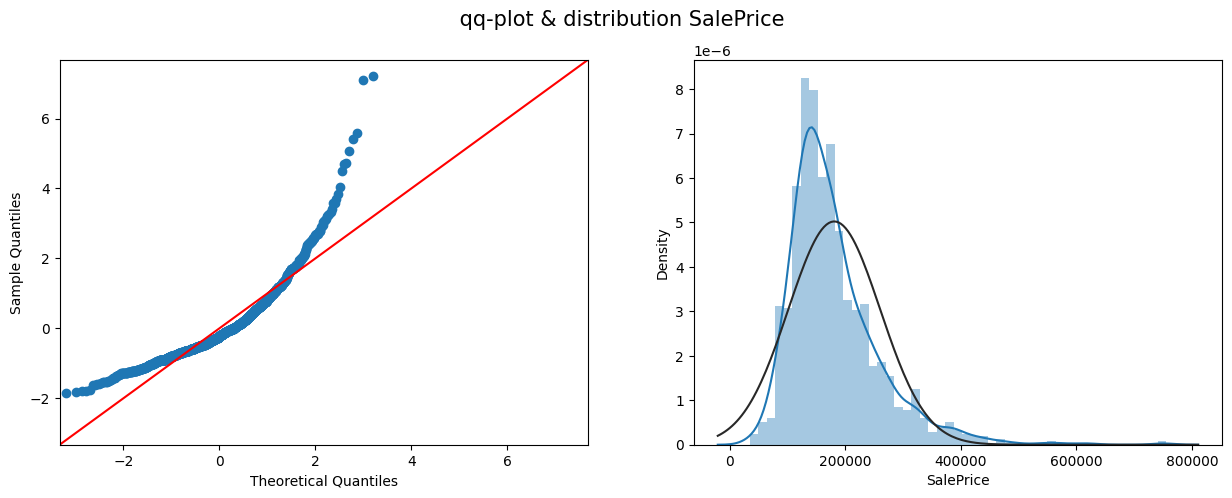

In [20]:
# SalePrice before transformation

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)
#I need to do furhter research into this, chatGPT isn't enough
sm.qqplot(target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])



sns.distplot(target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

C:\Users\NicholasTeng\AppData\Local\Temp\ipykernel_4756\1192839978.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_log, kde = True, hist=True, fit = norm, ax = ax[1])
c:\Users\NicholasTeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\NicholasTeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed i

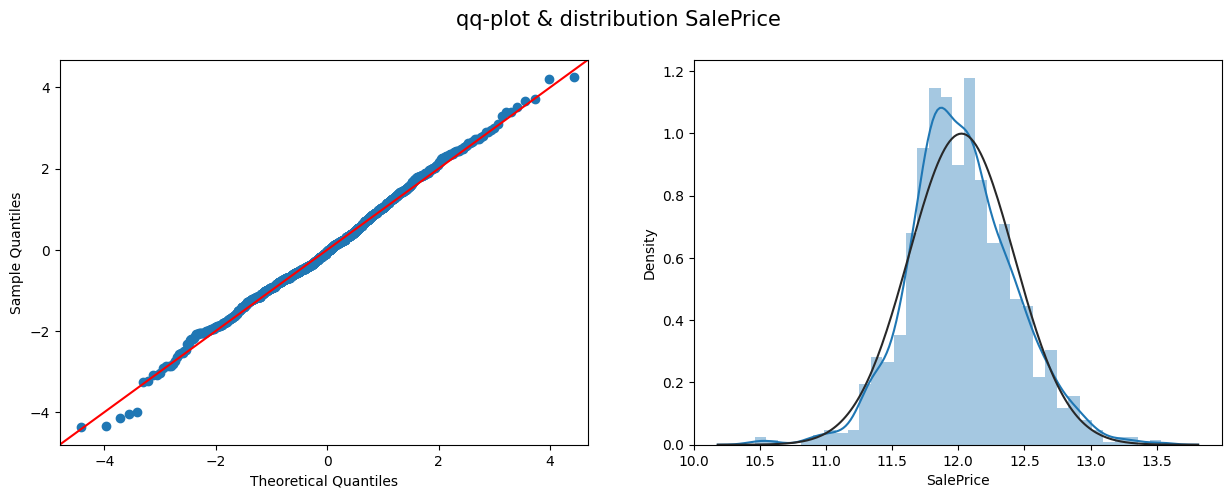

In [21]:
# SalePrice after transformation

target_log = np.log1p(target)

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target_log, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(target_log, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

#Check for skewness after doing log transformation

# Modelling Section

In [22]:
import shap
import xgboost as xgb
from catboost import Pool
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
 #Learn all of these packages!


# Data Splitting for Training and Testing

After completing data cleaning and enhancing it with additional features, the next step is to divide it back into training and testing sets. These sets will serve as the foundation for constructing multiple machine learning models. Ultimately, the most accurate model will be selected for further analysis and implementation.

In [23]:
# Train-Test separation

train = train_test_dummy[0:1460]
test = train_test_dummy[1460:]

test

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,4.394449,9.360741,5,1.945910,1961,0.000000,6.150603,4.976734,5.602119,6.783325,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.0
1461,4.406719,9.565775,6,1.945910,1958,4.691348,6.828712,0.000000,6.008813,7.192934,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.0
1462,4.317488,9.534668,5,1.791759,1997,0.000000,6.674561,0.000000,4.927254,6.834109,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.0
1463,4.369448,9.208238,6,1.945910,1998,3.044522,6.401917,0.000000,5.783825,6.831954,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.0
1464,3.784190,8.518392,8,1.791759,1992,0.000000,5.575949,0.000000,6.925595,7.155396,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,3.091042,7.568896,4,2.079442,1970,0.000000,0.000000,0.000000,6.304449,6.304449,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.0
2915,3.091042,7.546974,4,1.791759,1970,0.000000,5.533389,0.000000,5.686975,6.304449,...,0.0,0.0,0.0,1,0.693147,0.0,0.0,0.0,0,0.0
2916,5.081404,9.903538,5,2.079442,1960,0.000000,7.110696,0.000000,0.000000,7.110696,...,0.0,0.0,0.0,1,0.693147,0.0,0.0,0.0,0,0.0
2917,4.143135,9.253591,5,1.791759,1992,0.000000,5.823046,0.000000,6.356108,6.816736,...,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1,0.0


In [24]:
# Creation of the RMSE metric:
    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_log, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

# Evaluating Multiple Models

In pursuit of our goal, we will employ six distinct models to construct a robust ML model. Subsequently, their outcomes will be graphically compared to ascertain the most precise model.

# Candidate Models:

    1. Linear Regression
    2. Bayesian Ridge Regression
    3. Decision Tree Regressor
    4. Random Forest Regressor
    5. Cat Boost Regressor
    6. Stacked Regressor

Among the array of ML models considered, the Cat Boost Regressor exhibits the lowest CV_RMSE (Cross-Validated Root Mean Square Error). As a result, we will further fine-tune its parameters to maximize its predictive accuracy.


In [25]:
# 10 Fold Cross validation

kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

baseline_models = ['Linear_Reg.','Bayesian_Ridge_Reg.',
                   'Dec_Tree_Reg.','Random_Forest_Reg.',
                   'Cat_Boost_Reg.','Stacked_Reg.']

# Linear Regression

lreg = LinearRegression()
score_lreg = cv_rmse(lreg)
cv_scores.append(score_lreg.mean())
cv_std.append(score_lreg.std())

# Bayesian Ridge Regression

brr = BayesianRidge(compute_score=True)
score_brr = cv_rmse(brr)
cv_scores.append(score_brr.mean())
cv_std.append(score_brr.std())

# Light Gradient Boost Regressor

# l_gbm = LGBMRegressor(objective='regression')
# score_l_gbm = cv_rmse(l_gbm)
# cv_scores.append(score_l_gbm.mean())
# cv_std.append(score_l_gbm.std())

# Support Vector Regression

# svr = SVR()
# score_svr = cv_rmse(svr)
# cv_scores.append(score_svr.mean())
# cv_std.append(score_svr.std())

# Decision Tree Regressor

dtr = DecisionTreeRegressor()
score_dtr = cv_rmse(dtr)
cv_scores.append(score_dtr.mean())
cv_std.append(score_dtr.std())

# Random Forest Regressor

rfr = RandomForestRegressor()
score_rfr = cv_rmse(rfr)
cv_scores.append(score_rfr.mean())
cv_std.append(score_rfr.std())

# XGB Regressor

# xgb = xgb.XGBRegressor()
# score_xgb = cv_rmse(xgb)
# cv_scores.append(score_xgb.mean())
# cv_std.append(score_xgb.std())

# Gradient Boost Regressor

# gbr = GradientBoostingRegressor()
# score_gbr = cv_rmse(gbr)
# cv_scores.append(score_gbr.mean())
# cv_std.append(score_gbr.std())

# Cat Boost Regressor

catb = CatBoostRegressor()
score_catb = cv_rmse(catb)
cv_scores.append(score_catb.mean())
cv_std.append(score_catb.std())

# Stacked Regressor

stack_gen = StackingRegressor(regressors=(CatBoostRegressor(),
                                          LinearRegression(),
                                          BayesianRidge(),
                                         ),
                              meta_regressor = CatBoostRegressor(),
                              use_features_in_secondary = True)

score_stack_gen = cv_rmse(stack_gen)
cv_scores.append(score_stack_gen.mean())
cv_std.append(score_stack_gen.std())

final_cv_score = pd.DataFrame(baseline_models, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std

Learning rate set to 0.042748
0:	learn: 0.3836411	total: 143ms	remaining: 2m 22s
1:	learn: 0.3725519	total: 150ms	remaining: 1m 14s
2:	learn: 0.3631771	total: 156ms	remaining: 51.9s
3:	learn: 0.3540287	total: 163ms	remaining: 40.7s
4:	learn: 0.3451211	total: 170ms	remaining: 33.9s
5:	learn: 0.3369981	total: 176ms	remaining: 29.2s
6:	learn: 0.3279119	total: 183ms	remaining: 25.9s
7:	learn: 0.3196121	total: 189ms	remaining: 23.4s
8:	learn: 0.3116188	total: 195ms	remaining: 21.5s
9:	learn: 0.3044715	total: 201ms	remaining: 19.9s
10:	learn: 0.2971058	total: 207ms	remaining: 18.6s
11:	learn: 0.2908453	total: 214ms	remaining: 17.6s
12:	learn: 0.2840697	total: 221ms	remaining: 16.8s
13:	learn: 0.2779403	total: 228ms	remaining: 16.1s
14:	learn: 0.2717138	total: 236ms	remaining: 15.5s
15:	learn: 0.2667707	total: 243ms	remaining: 15s
16:	learn: 0.2617218	total: 251ms	remaining: 14.5s
17:	learn: 0.2559787	total: 259ms	remaining: 14.1s
18:	learn: 0.2504836	total: 266ms	remaining: 13.7s
19:	learn: 

X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


Learning rate set to 0.042748
0:	learn: 0.3851625	total: 5.7ms	remaining: 5.69s
1:	learn: 0.3748872	total: 10.5ms	remaining: 5.25s
2:	learn: 0.3652810	total: 15.4ms	remaining: 5.12s
3:	learn: 0.3562827	total: 20.4ms	remaining: 5.08s
4:	learn: 0.3476177	total: 25.8ms	remaining: 5.14s
5:	learn: 0.3385069	total: 32.2ms	remaining: 5.33s
6:	learn: 0.3300083	total: 37.6ms	remaining: 5.34s
7:	learn: 0.3215938	total: 42.4ms	remaining: 5.26s
8:	learn: 0.3135656	total: 47.2ms	remaining: 5.2s
9:	learn: 0.3061661	total: 52.5ms	remaining: 5.2s
10:	learn: 0.2986871	total: 57.7ms	remaining: 5.19s
11:	learn: 0.2921227	total: 62.7ms	remaining: 5.16s
12:	learn: 0.2850547	total: 67.7ms	remaining: 5.14s
13:	learn: 0.2786270	total: 73ms	remaining: 5.14s
14:	learn: 0.2725500	total: 78.1ms	remaining: 5.13s
15:	learn: 0.2668760	total: 83ms	remaining: 5.11s
16:	learn: 0.2610175	total: 88.2ms	remaining: 5.1s
17:	learn: 0.2553498	total: 93.4ms	remaining: 5.09s
18:	learn: 0.2499768	total: 98.4ms	remaining: 5.08s


X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


9:	learn: 0.3100422	total: 52.4ms	remaining: 5.18s
10:	learn: 0.3027148	total: 57.5ms	remaining: 5.17s
11:	learn: 0.2959010	total: 62.4ms	remaining: 5.13s
12:	learn: 0.2891555	total: 67.3ms	remaining: 5.11s
13:	learn: 0.2821328	total: 72.5ms	remaining: 5.1s
14:	learn: 0.2758750	total: 77.6ms	remaining: 5.09s
15:	learn: 0.2701384	total: 82.7ms	remaining: 5.08s
16:	learn: 0.2641892	total: 87.7ms	remaining: 5.07s
17:	learn: 0.2586816	total: 92.9ms	remaining: 5.07s
18:	learn: 0.2532028	total: 98ms	remaining: 5.06s
19:	learn: 0.2479794	total: 105ms	remaining: 5.14s
20:	learn: 0.2428753	total: 111ms	remaining: 5.17s
21:	learn: 0.2383318	total: 117ms	remaining: 5.2s
22:	learn: 0.2340212	total: 123ms	remaining: 5.21s
23:	learn: 0.2292915	total: 128ms	remaining: 5.2s
24:	learn: 0.2252297	total: 133ms	remaining: 5.2s
25:	learn: 0.2216567	total: 139ms	remaining: 5.2s
26:	learn: 0.2175454	total: 144ms	remaining: 5.18s
27:	learn: 0.2138335	total: 149ms	remaining: 5.17s
28:	learn: 0.2103223	total: 1

X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


13:	learn: 0.2788436	total: 66.3ms	remaining: 4.67s
14:	learn: 0.2725602	total: 71.2ms	remaining: 4.68s
15:	learn: 0.2668217	total: 75.9ms	remaining: 4.67s
16:	learn: 0.2611743	total: 80.8ms	remaining: 4.67s
17:	learn: 0.2552618	total: 85.8ms	remaining: 4.68s
18:	learn: 0.2501997	total: 90.5ms	remaining: 4.67s
19:	learn: 0.2451963	total: 95.4ms	remaining: 4.67s
20:	learn: 0.2402635	total: 100ms	remaining: 4.68s
21:	learn: 0.2352294	total: 105ms	remaining: 4.68s
22:	learn: 0.2309416	total: 110ms	remaining: 4.69s
23:	learn: 0.2264327	total: 116ms	remaining: 4.7s
24:	learn: 0.2224336	total: 120ms	remaining: 4.69s
25:	learn: 0.2184371	total: 125ms	remaining: 4.67s
26:	learn: 0.2145638	total: 131ms	remaining: 4.73s
27:	learn: 0.2110390	total: 138ms	remaining: 4.8s
28:	learn: 0.2074230	total: 145ms	remaining: 4.84s
29:	learn: 0.2038110	total: 151ms	remaining: 4.89s
30:	learn: 0.2005468	total: 157ms	remaining: 4.92s
31:	learn: 0.1969511	total: 164ms	remaining: 4.96s
32:	learn: 0.1937759	total

X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


Learning rate set to 0.042748
0:	learn: 0.3903529	total: 5.86ms	remaining: 5.86s
1:	learn: 0.3792939	total: 11.1ms	remaining: 5.52s
2:	learn: 0.3688372	total: 17.2ms	remaining: 5.73s
3:	learn: 0.3587373	total: 24.3ms	remaining: 6.05s
4:	learn: 0.3492997	total: 31ms	remaining: 6.17s
5:	learn: 0.3404921	total: 37.7ms	remaining: 6.24s
6:	learn: 0.3312501	total: 44.1ms	remaining: 6.26s
7:	learn: 0.3227176	total: 53ms	remaining: 6.57s
8:	learn: 0.3140226	total: 59ms	remaining: 6.5s
9:	learn: 0.3062282	total: 64.6ms	remaining: 6.4s
10:	learn: 0.2990914	total: 71.3ms	remaining: 6.41s
11:	learn: 0.2922180	total: 76.5ms	remaining: 6.29s
12:	learn: 0.2851329	total: 85.1ms	remaining: 6.46s
13:	learn: 0.2787463	total: 91.4ms	remaining: 6.43s
14:	learn: 0.2722775	total: 99.7ms	remaining: 6.54s
15:	learn: 0.2664500	total: 107ms	remaining: 6.56s
16:	learn: 0.2611068	total: 112ms	remaining: 6.48s
17:	learn: 0.2555923	total: 121ms	remaining: 6.59s
18:	learn: 0.2507325	total: 126ms	remaining: 6.53s
19:	

X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


Learning rate set to 0.042748
0:	learn: 0.3920758	total: 5.39ms	remaining: 5.39s
1:	learn: 0.3807781	total: 10.5ms	remaining: 5.25s
2:	learn: 0.3700069	total: 17ms	remaining: 5.64s
3:	learn: 0.3599895	total: 21.9ms	remaining: 5.46s
4:	learn: 0.3516325	total: 26.8ms	remaining: 5.33s
5:	learn: 0.3421381	total: 32.8ms	remaining: 5.43s
6:	learn: 0.3338667	total: 38.6ms	remaining: 5.47s
7:	learn: 0.3263965	total: 43.8ms	remaining: 5.43s
8:	learn: 0.3180865	total: 49.7ms	remaining: 5.47s
9:	learn: 0.3111507	total: 54.6ms	remaining: 5.41s
10:	learn: 0.3032336	total: 60.1ms	remaining: 5.4s
11:	learn: 0.2965049	total: 65.7ms	remaining: 5.41s
12:	learn: 0.2898229	total: 70.9ms	remaining: 5.38s
13:	learn: 0.2833842	total: 76.3ms	remaining: 5.37s
14:	learn: 0.2764093	total: 81.9ms	remaining: 5.38s
15:	learn: 0.2699542	total: 86.6ms	remaining: 5.33s
16:	learn: 0.2637705	total: 91.7ms	remaining: 5.3s
17:	learn: 0.2579912	total: 97.1ms	remaining: 5.3s
18:	learn: 0.2521515	total: 102ms	remaining: 5.27

X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


Learning rate set to 0.042748
0:	learn: 0.3814900	total: 6.91ms	remaining: 6.9s
1:	learn: 0.3708320	total: 12.8ms	remaining: 6.37s
2:	learn: 0.3604317	total: 17.8ms	remaining: 5.92s
3:	learn: 0.3514437	total: 23.8ms	remaining: 5.93s
4:	learn: 0.3420830	total: 28.7ms	remaining: 5.72s
5:	learn: 0.3332584	total: 33.6ms	remaining: 5.57s
6:	learn: 0.3245589	total: 39.2ms	remaining: 5.57s
7:	learn: 0.3165148	total: 44.1ms	remaining: 5.46s
8:	learn: 0.3086073	total: 49.3ms	remaining: 5.43s
9:	learn: 0.3010950	total: 54.4ms	remaining: 5.39s
10:	learn: 0.2934395	total: 59.6ms	remaining: 5.35s
11:	learn: 0.2864947	total: 64.4ms	remaining: 5.3s
12:	learn: 0.2801505	total: 69.3ms	remaining: 5.26s
13:	learn: 0.2735856	total: 74.7ms	remaining: 5.26s
14:	learn: 0.2669538	total: 80.1ms	remaining: 5.26s
15:	learn: 0.2612384	total: 84.7ms	remaining: 5.21s
16:	learn: 0.2562623	total: 90.3ms	remaining: 5.22s
17:	learn: 0.2507893	total: 95.8ms	remaining: 5.22s
18:	learn: 0.2460469	total: 100ms	remaining: 5

X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


Learning rate set to 0.042748
0:	learn: 0.3916223	total: 6.24ms	remaining: 6.24s
1:	learn: 0.3804310	total: 11ms	remaining: 5.48s
2:	learn: 0.3700285	total: 16.5ms	remaining: 5.49s
3:	learn: 0.3608080	total: 22.3ms	remaining: 5.55s
4:	learn: 0.3521305	total: 27.9ms	remaining: 5.54s
5:	learn: 0.3429175	total: 33.1ms	remaining: 5.48s
6:	learn: 0.3340669	total: 39.1ms	remaining: 5.55s
7:	learn: 0.3257503	total: 44.6ms	remaining: 5.53s
8:	learn: 0.3184227	total: 49.9ms	remaining: 5.5s
9:	learn: 0.3109088	total: 55.8ms	remaining: 5.52s
10:	learn: 0.3030398	total: 61.2ms	remaining: 5.5s
11:	learn: 0.2962001	total: 67.4ms	remaining: 5.55s
12:	learn: 0.2890393	total: 72.6ms	remaining: 5.51s
13:	learn: 0.2826845	total: 77.9ms	remaining: 5.48s
14:	learn: 0.2762555	total: 84.3ms	remaining: 5.53s
15:	learn: 0.2698238	total: 90ms	remaining: 5.54s
16:	learn: 0.2638102	total: 95.5ms	remaining: 5.52s
17:	learn: 0.2580767	total: 101ms	remaining: 5.53s
18:	learn: 0.2527721	total: 107ms	remaining: 5.55s


X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


Learning rate set to 0.042748
0:	learn: 0.3911657	total: 5.75ms	remaining: 5.74s
1:	learn: 0.3802619	total: 10.7ms	remaining: 5.32s
2:	learn: 0.3697673	total: 15.1ms	remaining: 5.02s
3:	learn: 0.3606059	total: 20.4ms	remaining: 5.09s
4:	learn: 0.3511446	total: 25ms	remaining: 4.98s
5:	learn: 0.3421299	total: 29.7ms	remaining: 4.92s
6:	learn: 0.3327104	total: 34.9ms	remaining: 4.95s
7:	learn: 0.3247262	total: 39.3ms	remaining: 4.87s
8:	learn: 0.3161864	total: 43.8ms	remaining: 4.82s
9:	learn: 0.3085759	total: 48.9ms	remaining: 4.85s
10:	learn: 0.3014919	total: 53.6ms	remaining: 4.82s
11:	learn: 0.2940431	total: 58.2ms	remaining: 4.79s
12:	learn: 0.2873903	total: 62.8ms	remaining: 4.76s
13:	learn: 0.2808558	total: 68.1ms	remaining: 4.79s
14:	learn: 0.2746293	total: 72.7ms	remaining: 4.78s
15:	learn: 0.2682811	total: 77.8ms	remaining: 4.78s
16:	learn: 0.2628830	total: 83.1ms	remaining: 4.81s
17:	learn: 0.2576469	total: 88.1ms	remaining: 4.81s
18:	learn: 0.2521712	total: 92.8ms	remaining: 

X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


4:	learn: 0.3529543	total: 31.6ms	remaining: 6.29s
5:	learn: 0.3443446	total: 37.3ms	remaining: 6.18s
6:	learn: 0.3349863	total: 43.8ms	remaining: 6.22s
7:	learn: 0.3264978	total: 49.4ms	remaining: 6.13s
8:	learn: 0.3182811	total: 55.8ms	remaining: 6.14s
9:	learn: 0.3106864	total: 63ms	remaining: 6.23s
10:	learn: 0.3032744	total: 67.7ms	remaining: 6.09s
11:	learn: 0.2962805	total: 73.5ms	remaining: 6.05s
12:	learn: 0.2888413	total: 79.5ms	remaining: 6.03s
13:	learn: 0.2822765	total: 84.5ms	remaining: 5.95s
14:	learn: 0.2760289	total: 90.9ms	remaining: 5.97s
15:	learn: 0.2707458	total: 95.7ms	remaining: 5.89s
16:	learn: 0.2654307	total: 101ms	remaining: 5.82s
17:	learn: 0.2596509	total: 108ms	remaining: 5.9s
18:	learn: 0.2546821	total: 113ms	remaining: 5.84s
19:	learn: 0.2495755	total: 118ms	remaining: 5.78s
20:	learn: 0.2443570	total: 125ms	remaining: 5.81s
21:	learn: 0.2398266	total: 131ms	remaining: 5.82s
22:	learn: 0.2349931	total: 136ms	remaining: 5.77s
23:	learn: 0.2305344	total: 

X has feature names, but LinearRegression was fitted without feature names
X has feature names, but BayesianRidge was fitted without feature names


In [26]:
final_cv_score

,Regressors,RMSE_mean,RMSE_std
0,Linear_Reg.,0.140991,0.029119
1,Bayesian_Ridge_Reg.,0.126268,0.025034
2,Dec_Tree_Reg.,0.198612,0.024193
3,Random_Forest_Reg.,0.140100,0.024031
4,Cat_Boost_Reg.,0.118735,0.018311
5,Stacked_Reg.,0.119119,0.019450


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


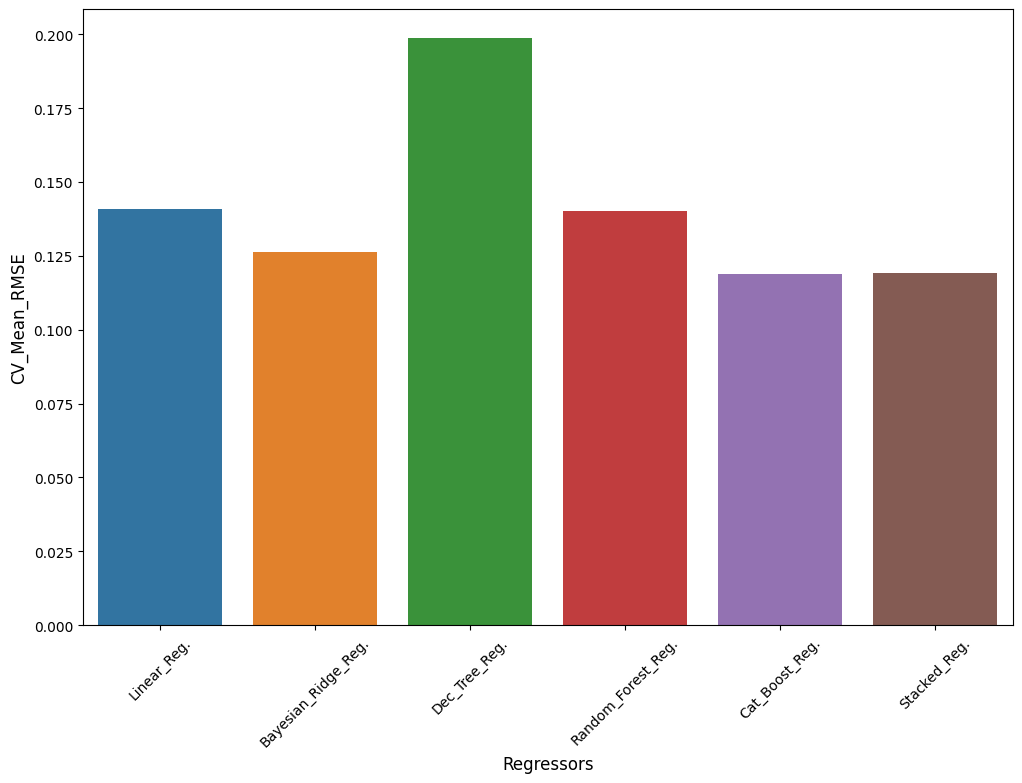

In [27]:
plt.figure(figsize = (12,8))
sns.barplot(x = final_cv_score['Regressors'],y = final_cv_score['RMSE_mean'])
plt.xlabel('Regressors', fontsize = 12)
plt.ylabel('CV_Mean_RMSE', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

In [48]:
X_train,X_val,y_train,y_val = train_test_split(train,target_log,test_size = 0.1,random_state=42)

# Cat Boost Regressor

cat = CatBoostRegressor()
cat_model = cat.fit(X_train,y_train,
                     eval_set = (X_val,y_val),
                     plot=True,
                     verbose = 0)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
cat_pred = cat_model.predict(X_val)
cat_score = rmse(y_val, cat_pred)
cat_score

0.11060803500827655

In [30]:
feat_imp = cat_model.get_feature_importance(prettified=True)
feat_imp

,Feature Id,Importances
0,OverallQual,17.686474
1,HighQualSF,7.510705
2,Total_Home_Quality,6.552617
3,GrLivArea,5.833551
4,YearBuilt,5.668696
...,...,...
331,Fence_GdPrv,0.000000
332,MiscFeature_None,0.000000
333,MiscFeature_Othr,0.000000
334,MiscFeature_TenC,0.000000


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


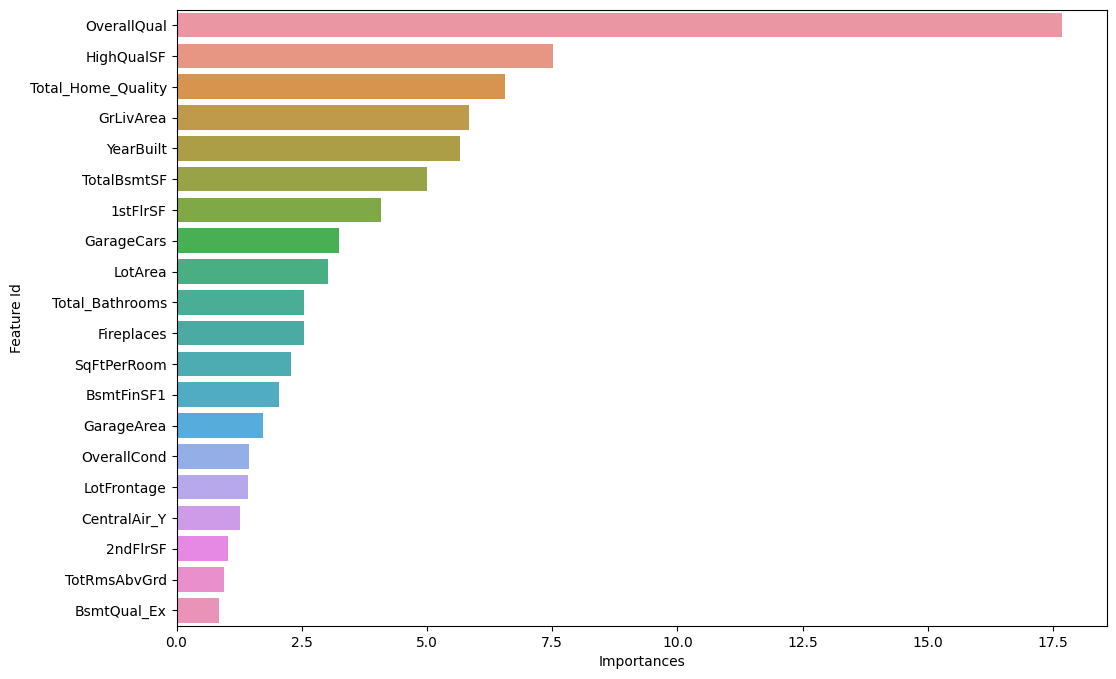

In [31]:
plt.figure(figsize = (12,8))
sns.barplot(x= feat_imp['Importances'][:20],y = feat_imp['Feature Id'][:20], orient = 'h')
plt.show()

In [32]:
# Features' Interactions
train_data = Pool(X_train)

interaction = cat_model.get_feature_importance(train_data, type="Interaction")
column_names = X_train.columns.values 
interaction = pd.DataFrame(interaction, columns=["feature1", "feature2", "importance"])
interaction.feature1 = interaction.feature1.apply(lambda l: column_names[int(l)])
interaction.feature2 = interaction.feature2.apply(lambda l: column_names[int(l)])
interaction.head(20)

,feature1,feature2,importance
0,LotArea,YearBuilt,0.501144
1,LotArea,OverallQual,0.450628
2,LotArea,1stFlrSF,0.408368
3,LotArea,SqFtPerRoom,0.400879
4,OverallQual,HighQualSF,0.372949
5,OverallQual,1stFlrSF,0.359629
6,OverallQual,SqFtPerRoom,0.357647
7,OverallQual,2ndFlrSF,0.334393
8,OverallQual,Functional_Sev,0.330965
9,OverallQual,GrLivArea,0.330038


# Hyperparameter Optimization with Randomized Search

To discover the optimal CatBoost parameters tailored to our dataset, we employ the "randomized_search" function. This function systematically explores different hyperparameter combinations, ultimately plotting a graph to pinpoint the configuration that yields the lowest Root Mean Square Error (RSME).

Subsequently, these finely-tuned hyperparameters, specifically a depth of 6, learning rate of 0.05, l2_leaf_reg of 5, and 6000 iterations, will be integrated into the final CatBoost Regressor.

This meticulous hyperparameter selection process ensures that our model is finely-tuned to deliver the best possible performance on the given dataset.

In [33]:
# Preforming a Random Grid Search to find the best combination of parameters

# grid = {'iterations': [1000,6000],
#         'learning_rate': [0.05, 0.005, 0.0005],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 9]}

# final_model = CatBoostRegressor()
# randomized_search_result = final_model.randomized_search(grid,
#                                                    X = X_train,
#                                                    y= y_train,
#                                                    verbose = False,
#                                                    plot=True)

# Final CatBoost Parameters

In addition to incorporating insights from the "randomized_search", the verbose parameter is now set to 200. This ensures that training information will be provided at intervals of 200 iterations, allowing for efficient monitoring of the training process.

Furthermore, the early_stopping_rounds parameter is established at 200. This mechanism acts as a safeguard, halting the training process if performance fails to improve for a specified number of consecutive iterations. This not only conserves computational resources but also prevents prolonged training without discernible enhancement in results.

As a result of these strategic parameter adjustments, a remarkable catf_score of 0.1072(4 s.f.) has been achieved. This reflects the model's exceptional predictive accuracy and efficiency.

In [34]:
# Final Cat-Boost Regressor

params = {'iterations': 6000,
          'learning_rate': 0.05,
          'depth': 6,
          'l2_leaf_reg': 5,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 500,
          'verbose': 200,
          'random_seed': 42}
         
cat_f = CatBoostRegressor(**params)
cat_model_f = cat_f.fit(X_train,y_train,
                     eval_set = (X_val,y_val),
                     plot=True,
                     verbose = False)

catf_pred = cat_model_f.predict(X_val)
catf_score = rmse(y_val, catf_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [47]:
print("Catf Score:", catf_score)

Catf Score: 0.10716856468827729


# Results Analysis

To assess the model's efficacy, an in-depth analysis was conducted. This involved predicting the SalesPrice for the training data and subsequently comparing it with the actual SalesPrice values. The resulting median accuracy achieved an impressive 99.6%. However, such a high accuracy score prompts considerations about potential overfitting.

As a precautionary measure, it is advisable to focus on utilizing only the top 10 features with the highest correlation. This targeted approach aims to enhance the model's generalization capability. Furthermore, the newly engineered features, while showing promise, necessitate thorough validation to confirm their contribution to improved accuracy before their integration into the model. This rigorous validation process will optimize the model's performance while mitigating the risk of overfitting.

But for now, this result will be used for the Kaggle submission.

In [46]:
train_pred = cat_f.predict(train)
train_pred = np.expm1(train_pred)
new_sub = pd.DataFrame(train_id, columns = ['Id'])
new_sub['PredSalePrice'] = train_pred
new_sub['True SalePrice'] = target

new_sub.head()
avg_accuracy = (new_sub['PredSalePrice']/new_sub['True SalePrice']) * 100
print(avg_accuracy.median())

99.62983743365311


# Preparing CSV Submission File

In the final step of the process, we utilize the trained CatBoost regressor model to generate predictions. The use of np.expm1(test_pred) is essential to revert the predictions back to their original scale, as the target variables were initially logarithmically transformed to address skewness.

Subsequently, the DataFrame is converted into a CSV file format, ready for submission to Kaggle. This submission resulted in a commendable score of 0.1287. This step marks the culmination of the model deployment and evaluation process.

In [39]:
# Test CSV Submission

test_pred = cat_f.predict(test)
submission = pd.DataFrame(test_id, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred 
submission.head()

,Id,SalePrice
0,1461,129902.776083
1,1462,162600.145427
2,1463,178995.642153
3,1464,192203.039102
4,1465,183378.316374


In [ ]:
# Saving the results in a csv file

submission.to_csv("result.csv", index = False, header = True)